# A3: Kernel Ridge Regression and Bootstrap

# Kernel Ridge Regression Project Overview

## Problem Description

The project involves implementing Kernel Ridge Regression for a synthetic dataset. The dataset contains \( n = 30 \) observations generated using the function \( f^*(x) = 4\sin(\pi x)\cos(6\pi x^2) \) plus some random Gaussian noise.

The main objectives of the project are as follows:

### Part A:
- Use leave-one-out cross-validation to find optimal hyperparameters for two different types of kernels:
  - Polynomial Kernel \( k_{\text{poly}}(x,z) = (1 + x^Tz)^d \), where \( d \) is a hyperparameter
  - RBF Kernel \( k_{\text{rbf}}(x,z) = \exp(-\gamma ||x - z||^2) \), where \( \gamma > 0 \) is a hyperparameter
- Find the best \( \lambda \), \( d \), and \( \gamma \) for both kernels.

### Part B:
- Plot the original data points \( (x_i, y_i) \), the true function \( f(x) \), and the predicted function \( \hat{f}(x) \).

### Part C:
- Use non-parametric bootstrap with \( B = 300 \) iterations to construct 5% and 95% confidence intervals for \( \hat{f}_{\text{poly}}(x) \) and \( \hat{f}_{\text{rbf}}(x) \).

### Part D:
- Repeat parts A, B, and C for \( n = 300 \) and use 10-fold cross-validation instead of leave-one-out.

### Part E:
- Evaluate if \( \hat{f}_{\text{poly}} \) or \( \hat{f}_{\text{rbf}} \) is statistically better at predicting \( Y \) from \( X \) based on a new set of \( m = 1000 \) samples.

## Implementation Highlights

- The optimal hyperparameters for each kernel are found using cross-validation.
- Kernel Ridge Regression is employed to learn a mapping from \( x \) to \( y \).
- Bootstrap techniques are used to estimate confidence intervals for the predicted functions.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import scipy.optimize
from scipy.optimize import minimize
import scipy.linalg as la
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
import time

## Target Function

In [2]:
def funk(x):
    """
    Calculate the value of the function f(x) = 4 * sin(pi * x) * cos(6 * pi * x^2).
    
    Parameters:
        x : float or numpy array
            The input value or array of values for which f(x) will be calculated.
            
    Returns:
        float or numpy array : The value(s) of f(x).
    """
    return 4 * np.sin(np.pi * x) * np.cos(6 * np.pi * (x)**2)

## Generate Synthetic data

In [3]:
'''Generating Data'''

# Set the number of data points
n = 30

# Declare global variables x_a3 and y_a3
global x_a3, y_a3

# Generate random x-values using numpy's random function, creating an array of length n
x_a3 = np.random.rand(n)

# Generate random noise using numpy's standard normal distribution, creating an array of length n
e_a3 = np.random.randn(n)

# Generate y-values based on the function `funk` and add the random noise e_a3
y_a3 = funk(x_a3) + e_a3

## Visualizing the Actual Function and Data Points

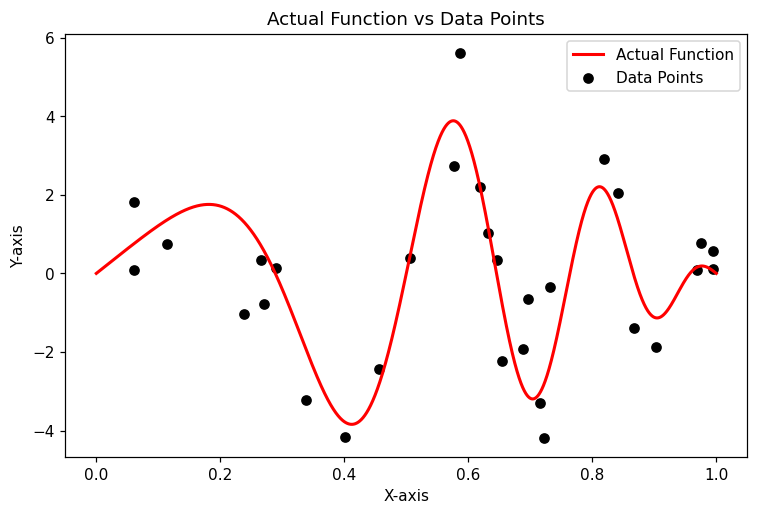

In [4]:
# Create a figure with custom dimensions and resolution
plt.figure(figsize=(8, 5), dpi=110)

# Generate 10,000 points between 0 and 1 to plot the actual function
x_shape = np.linspace(0, 1, 10000)

# Calculate the corresponding y-values using the actual function
y_shape = funk(x_shape)

# Plot the actual function in red with a smooth line
plt.plot(x_shape, y_shape, 'r', label='Actual Function', linewidth=2)

# Plot the original data points in black
plt.scatter(x_a3, y_a3, color='black', marker='o', label='Data Points')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Actual Function vs Data Points')

# Add legend for clarity
plt.legend(loc="best")

# Show the plot
plt.show()

## Polynomial Kernel Function

In [5]:
def kernel_poly(x, z, d):
    """
    Compute the polynomial kernel between two points x and z.
    
    Parameters:
        x : float
            The first input point.
        z : float
            The second input point.
        d : int
            The degree of the polynomial.
            
    Returns:
        float : The polynomial kernel value between x and z.
    """
    return (1 + x.T * z) ** d

## Radial Basis Function (RBF) Kernel

In [6]:
def kernel_rbf(x, z, gamma):
    """
    Compute the RBF (Radial Basis Function) kernel between two points x and z.
    
    Parameters:
        x : float
            The first input point.
        z : float
            The second input point.
        gamma : float
            The gamma parameter of the RBF kernel.
            
    Returns:
        float : The RBF kernel value between x and z.
    """
    return np.exp(-gamma * ((x.T - z) ** 2))

## Kernel Ridge Regression Function

In [7]:
def kernel_ridge_regression(K, y, lamb):
    """
    Perform Kernel Ridge Regression on given kernel matrix and target values.
    
    Parameters:
        K : numpy.ndarray
            The kernel matrix.
        y : numpy.ndarray
            The target values.
        lamb : float
            The regularization parameter (lambda).
            
    Returns:
        numpy.ndarray : The alpha values.
    """
    I = np.identity(np.size(y))
    return np.linalg.pinv(K + lamb * I) @ y

# Additional Functions for Kernel Ridge Regression Project
## Polynomial Prediction Function

In [8]:
def poly_predicted_funk(x, alpha, X, hyperparameter):
    """
    Compute the predicted value for a given point x using polynomial kernel.
    
    Parameters:
        x : float
            The input point for which prediction is required.
        alpha : numpy.ndarray
            The alpha coefficients.
        X : numpy.ndarray
            The training data.
        hyperparameter : float
            The hyperparameter for the polynomial kernel.
            
    Returns:
        float : The predicted value for x.
    """
    ans = 0
    for i in range(np.size(X)):
        ans += alpha[i] * kernel_poly(X[i], x, hyperparameter)
    return ans  # Fixed the typo from 'and' to 'ans'

## Radial Basis Function (RBF) Prediction Function

In [9]:
def rbf_predicted_funk(x, alpha, X, hyperparameter):
    """
    Compute the predicted value for a given point x using RBF kernel.
    
    Parameters:
        x : float
            The input point for which prediction is required.
        alpha : numpy.ndarray
            The alpha coefficients.
        X : numpy.ndarray
            The training data.
        hyperparameter : float
            The hyperparameter for the RBF kernel.
            
    Returns:
        float : The predicted value for x.
    """
    ans = 0
    for i in range(np.size(X)):
        ans += alpha[i] * kernel_rbf(X[i], x, hyperparameter)
    return ans  # Fixed the typo from 'and' to 'ans'

## Leave-One-Out Error Calculation for Polynomial Kernel

In [10]:
def mini_poly_leave_one_out_error(input):
    """
    Calculate the leave-one-out error for polynomial kernel.
    
    Parameters:
        input : list
            A list containing the hyperparameter and regularization parameter lambda.
            
    Returns:
        float : The leave-one-out error.
    """
    x = x_a3
    y = y_a3
    n = len(x)
    predi = np.zeros(n)
    hyperparameter, lamb = input[0], input[-1]
    e = 0
    
    for i in range(n):
        A = list(range(0, n))
        A = np.array(A)
        A = A[A != A[i]]
        
        train_x = x[x != x[i]]
        train_y = y[y != y[i]]
        
        K = np.zeros((n-1, n-1))
    
        for ii in A:
            for jj in A:
                iii = np.where(A == ii)[0][0]
                jjj = np.where(A == jj)[0][0]
                K[iii, jjj] = kernel_poly(x[iii], x[jjj], int(hyperparameter))
        
        alpha = kernel_ridge_regression(K, train_y, lamb)
        
        pre = poly_predicted_funk(x[i], alpha, train_x, hyperparameter)
        predi[i] = pre
        e += (pre - y[i]) ** 2
        
    return e / n

## Leave-One-Out Error Calculation for Radial Basis Function (RBF) Kernel

In [11]:
def mini_rbf_leave_one_out_error(input):
    """
    Calculate the leave-one-out error for the Radial Basis Function (RBF) kernel.
    
    Parameters:
        input : list
            A list containing the hyperparameter and regularization parameter lambda.
            
    Returns:
        float : The leave-one-out error.
    """
    
    x = x_a3  # Using global variable
    y = y_a3  # Using global variable
    n = len(x)
    predi = np.zeros(n)
    hyperparameter, lamb = input[0], input[-1]
    e = 0
    
    # Loop over all data points
    for i in range(n):
        
        # Generate an array A of indices, removing the current index i
        A = list(range(0, n))
        A = np.array(A)
        A = A[A != A[i]]
        
        # Generate training set by removing one observation
        train_x = x[x != x[i]]
        train_y = y[y != y[i]]
        
        # Initialize kernel matrix K
        K = np.zeros((n-1, n-1))
    
        # Compute the kernel matrix K for the training set
        for ii in A:
            for jj in A:
                iii = np.where(A == ii)[0][0]
                jjj = np.where(A == jj)[0][0]
                K[iii, jjj] = kernel_rbf(x[iii], x[jjj], hyperparameter)
        
        # Compute the alpha coefficients using kernel ridge regression
        alpha = kernel_ridge_regression(K, train_y, lamb)
        
        # Calculate the predicted value for the left-out observation
        pre = rbf_predicted_funk(x[i], alpha, train_x, hyperparameter)
        
        # Store the predicted value
        predi[i] = pre
        
        # Compute the error
        e += (pre - y[i]) ** 2
    
    return e / n  # Return the mean squared error

# A3. a)

## Polynomial Kernel Ridge Regression Optimization

In [12]:
'''POLY'''
x0=[40,1]
bnds=((30,50),(0,1))
poly_result=minimize(mini_poly_leave_one_out_error, x0,tol=1e-11, bounds=bnds)
poly_result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 4536503601547401.0
        x: [ 3.000e+01  1.000e+00]
      nit: 1
      jac: [ 5.818e+15 -3.876e+17]
     nfev: 6
     njev: 2
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

## RBF Kernel Ridge Regression Optimization

In [13]:
'''RBF'''
x0=[20,1]
bnds=((0,None),(0,None))
rbf_result=minimize(mini_rbf_leave_one_out_error, x0,tol=1e-10, bounds=bnds)
rbf_result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3.262796537189493
        x: [ 2.869e+02  2.081e+00]
      nit: 29
      jac: [-8.882e-08 -1.377e-06]
     nfev: 156
     njev: 52
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

# A3. b)

## Title: Kernel Ridge Regression Predictions and Visualization

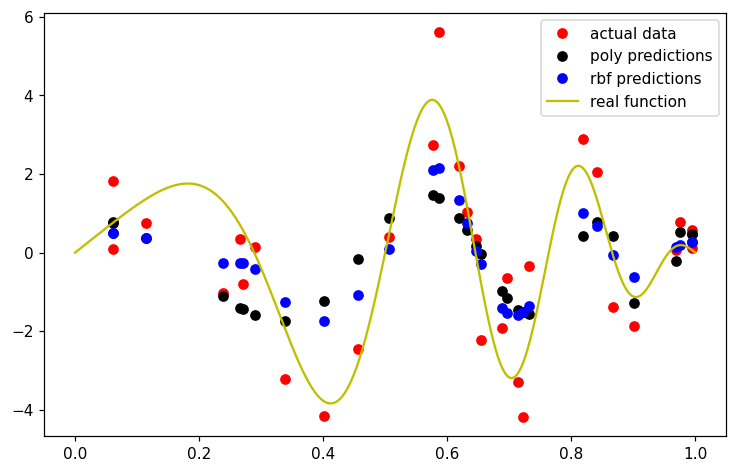

In [14]:
# Title: Kernel Ridge Regression Predictions and Visualization

# Initialization
x, y, n = x_a3, y_a3, len(x_a3)
rbf_prediction = np.zeros(n)  # Initialize RBF kernel predictions array
poly_prediction = np.zeros(n)  # Initialize Polynomial kernel predictions array

# Polynomial Kernel Predictions
# Extracting optimized hyperparameters for polynomial kernel
hyperparameter_poly, lamb_poly = poly_result.x

# Note: The hyperparameter for the polynomial kernel degree must be an integer.
# Hence, it's often rounded to the nearest integer in some implementations.
#hyperparameter_poly = int(hyperparameter_poly)

# Construct the Polynomial Kernel matrix K_poly
K_poly = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K_poly[i, j] = kernel_poly(x[i], x[j], hyperparameter_poly)

# Calculate the alpha coefficients for polynomial kernel
alpha_poly = kernel_ridge_regression(K_poly, y, lamb_poly)

# Make predictions using the Polynomial Kernel
for i in range(n):
    poly_prediction[i] = poly_predicted_funk(x[i], alpha_poly, x, hyperparameter_poly)

# RBF Kernel Predictions
# Extracting optimized hyperparameters for RBF kernel
hyperparameter_rbf, lamb_rbf = rbf_result.x

# Construct the RBF Kernel matrix K_rbf
K_rbf = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K_rbf[i, j] = kernel_rbf(x[i], x[j], hyperparameter_rbf)

# Calculate the alpha coefficients for RBF kernel
alpha_rbf = kernel_ridge_regression(K_rbf, y, lamb_rbf)

# Make predictions using the RBF Kernel
for i in range(n):
    rbf_prediction[i] = rbf_predicted_funk(x[i], alpha_rbf, x, hyperparameter_rbf)

# Plotting Predictions and Actual Data
plt.figure(figsize=(8, 5), dpi=110)
plt.plot(x_a3, y_a3, 'o', color='red', label='actual data')  # Plot actual data points
plt.plot(x_a3, poly_prediction, 'o', color='black', label='poly predictions')  # Plot Polynomial Kernel predictions
plt.plot(x_a3, rbf_prediction, 'o', color='blue', label='rbf predictions')  # Plot RBF Kernel predictions
plt.plot(x_shape, y_shape, 'y', label='real function')  # Plot the underlying true function
plt.legend(loc="best")  # Show legend

plt.show()  # Display the plot


# A3. c)

## Assumed functions and data: kernel_poly, kernel_rbf, kernel_ridge_regression, x_a3, y_a3

/var/folders/z3/bkgw4vw17fx7qmlcf7_4tdd00000gn/T/ipykernel_83530/1123311026.py:112: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X0,Y0,'b--',color='black',label='actuall data')


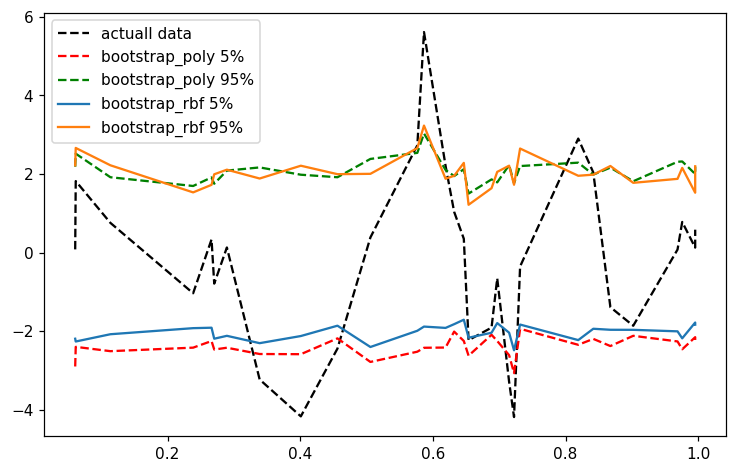

In [15]:
B=300
n=30
x_draw=np.zeros((n,B))
y_draw=np.zeros((n,B))
forecast_rbf=np.zeros((n,B))
forecast_poly=np.zeros((n,B))

for b in range(B):
    
    '''Generating data'''
    for j in range(n):
        draw=rand.randrange(0,n)
        x_draw[j,b]=x_a3[draw]
        y_draw[j,b]=y_a3[draw]
    
    
    
    x=x_draw[:,b]
    y=y_draw[:,b]
    
    
    
    '''POLY'''
    
    K_poly=np.zeros((n,n))
    for i in range(n):
        for j in range(n):   
            K_poly[i,j]=kernel_poly(x[i],x[j],hyperparameter_poly)
            
    alpha_poly=kernel_ridge_regression(K_poly,y,lamb_poly)  
    for i in range(n):
        forecast_poly[i,b]=poly_predicted_funk(x[i],alpha_poly,x,hyperparameter_poly)

    
    
    '''RBF'''
    K_rbf=np.zeros((n,n))
    for i in range(n):
        for j in range(n):   
            K_rbf[i,j]=kernel_rbf(x[i],x[j],hyperparameter_rbf)
    alpha_rbf=kernel_ridge_regression(K_rbf,y,lamb_rbf)  
    for i in range(n):
        forecast_rbf[i,b]=rbf_predicted_funk(x[i],alpha_rbf,x,hyperparameter_rbf)

    
'''Making the confidence intervals'''

bootstrap_rbf=np.zeros((n,2))
bootstrap_poly=np.zeros((n,2))

for i in range(n):
    
    '''Poly'''
    order_y=np.zeros(B*n)
    ii=0
    for b in range(B):
        for j in range(n):
            if x_draw[j,b]==x_a3[i]:
                order_y[ii]+=forecast_poly[i,b]
                ii+=1
    order_y=order_y[0:ii]
    order=order_y
    order.sort()

    one=order[int(0.05*len(order))]
    two=order[int(0.95*len(order))]

    one=np.where(order==one)[0][0]
    two=np.where(order==two)[0][0]
    
    bootstrap_poly[i,0]=order[one]
    bootstrap_poly[i,1]=order[two]
    
    
    '''RBF'''
    order_y=np.zeros(B*n)
    ii=0
    for b in range(B):
        for j in range(n):
            if x_draw[j,b]==x_a3[i]:
                order_y[ii]+=forecast_rbf[i,b]
                ii+=1
    order_y=order_y[0:ii]
    order=order_y
    order.sort()
    

    one=order[int(0.05*len(order))]
    two=order[int(0.95*len(order))]

    one=np.where(order==one)[0][0]
    two=np.where(order==two)[0][0]
    
    bootstrap_rbf[i,0]=order[one]
    bootstrap_rbf[i,1]=order[two]
    
    
    
    
'''to get a good plot we need to sort them all now'''

Y1 = [x for _,x in sorted(zip(x_a3,bootstrap_poly[:,0]))]
Y2 = [x for _,x in sorted(zip(x_a3,bootstrap_poly[:,1]))]
Y3 = [x for _,x in sorted(zip(x_a3,bootstrap_rbf[:,0]))]
Y4 = [x for _,x in sorted(zip(x_a3,bootstrap_rbf[:,1]))]

X0=x_a3
Y0= [x for _,x in sorted(zip(x_a3,y_a3))]
X0.sort()

plt.figure(figsize=(8, 5), dpi=110)
plt.plot(X0,Y0,'b--',color='black',label='actuall data')
plt.plot(X0,Y1,'r--',label='bootstrap_poly 5%')
plt.plot(X0,Y2,'g--',label='bootstrap_poly 95%')
plt.plot(X0,Y3,label='bootstrap_rbf 5%')
plt.plot(X0,Y4,label='bootstrap_rbf 95%')

plt.legend(loc="best")
plt.show()

# A3. d) 10-fold CV instead of leave-one-out

## Title: 10-Fold Cross-Validation and Data Generation in Kernel Ridge Regression

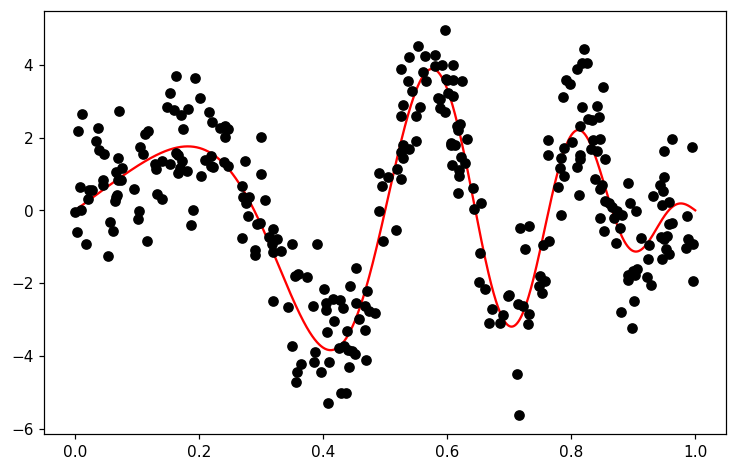

In [16]:
'''Generating data'''
n=300
np.random.seed(313)
global x_a3,y_a3
x_a3_d=np.random.rand(n)
e_a3_d=np.random.randn(n)

y_a3_d=funk(x_a3_d)+e_a3_d

x_a3=x_a3_d
y_a3=y_a3_d

plt.figure(figsize=(8, 5), dpi=110)
x_shape=np.linspace(0,1,10000)
y_shape=funk(x_shape)
plt.plot(x_shape,y_shape,'r')
plt.plot(x_a3,y_a3,'o', color='black')
plt.show()

## Mini-Batch 10-Fold Cross-Validation for Polynomial Kernel Ridge Regression

In [17]:
# Title: Mini-Batch 10-Fold Cross-Validation for Polynomial Kernel Ridge Regression

def mini_poly_k_fold_error(innput):
    # Initialize variables and hyperparameters
    x=x_a3
    y=y_a3
    n=len(x)
    predi=np.zeros(n)
    hyperparameter,lamb=innput[0],innput[-1]
    e=0  # Error accumulator
    N=10  # Fold size
    
    # Loop through each fold in the 10-fold cross-validation
    for fold in range(int(n/10)):
        
        # Generate index sets for the training and test data
        All=np.array(list(range(0,n)))            
        if fold==0: 
            A_idx=list(range(0,n))[None:10]
        else: 
            A_idx=list(range(0,n))[fold*N:fold*N+N] 
        idx = np.ones(n,dtype=bool)
        idx[A_idx] = False
        A=All[idx]
        B=All[~idx]
        train_x=x[idx]
        train_y=y[idx]
        
        # Construct the kernel matrix K for polynomial kernel
        K=np.zeros((n-N,n-N))
        for ii in A:
            for jj in A:
                iii=np.where(A==ii)[0][0]
                jjj=np.where(A==jj)[0][0]
                K[iii,jjj]=kernel_poly(x[iii],x[jjj],int(hyperparameter))
        
        # Compute alpha using kernel ridge regression
        alpha=kernel_ridge_regression(K,train_y,lamb)  
        
        # Compute error for this fold
        for i in B:
            e+=(poly_predicted_funk(x[i],alpha,train_x,hyperparameter)-y[i])**2
            
    return e/(n/N)  # Return the average error


## Mini-Batch 10-Fold Cross-Validation for RBF Kernel Ridge Regression

In [18]:
def mini_rbf_k_fold_error(innput):
    # Initialize variables and hyperparameters
    x = x_a3
    y = y_a3
    n = len(x)
    predi = np.zeros(n)
    hyperparameter, lamb = innput[0], innput[-1]
    e = 0  # Error accumulator
    
    N = 10  # Fold size
    
    # Loop through each fold in the 10-fold cross-validation
    for fold in range(int(n / 10)):
        
        # Generate index sets for the training and test data
        All = np.array(list(range(0, n)))  
        if fold == 0: 
            A_idx = list(range(0, n))[None:10]
        else: 
            A_idx = list(range(0, n))[fold * N:fold * N + N]
        
        idx = np.ones(n, dtype=bool)
        idx[A_idx] = False
        A = All[idx]
        B = All[~idx]
        train_x = x[idx]
        train_y = y[idx]
        
        # Construct the kernel matrix K for RBF kernel
        K = np.zeros((n - N, n - N))
        for ii in A:
            for jj in A:
                iii = np.where(A == ii)[0][0]
                jjj = np.where(A == jj)[0][0]
                K[iii, jjj] = kernel_rbf(x[iii], x[jjj], int(hyperparameter))
        
        # Compute alpha using kernel ridge regression
        alpha = kernel_ridge_regression(K, train_y, lamb)  
        
        # Compute error for this fold
        for i in B:
            e += (rbf_predicted_funk(x[i], alpha, train_x, hyperparameter) - y[i]) ** 2
            
    return e / (n / N)  # Return the average error

## Title: Hyperparameter Optimization for Polynomial Kernel using K-Fold CV

In [19]:
'''K-Fold POLY'''
x0=[40,1]
bnds=((0,100),(0,1.5))
poly_result=minimize(mini_poly_k_fold_error, x0, bounds=bnds)
#poly_result

## Title: Hyperparameter Optimization for RBF Kernel using K-Fold CV

In [20]:
'''K-Fold RBF'''
x0=[227,3]
bnds=((0,300),(0,1.5))
rbf_result=minimize(mini_rbf_k_fold_error, x0, bounds=bnds)
#rbf_result

## Title: Kernel Ridge Regression Predictions with Optimal Hyperparameters

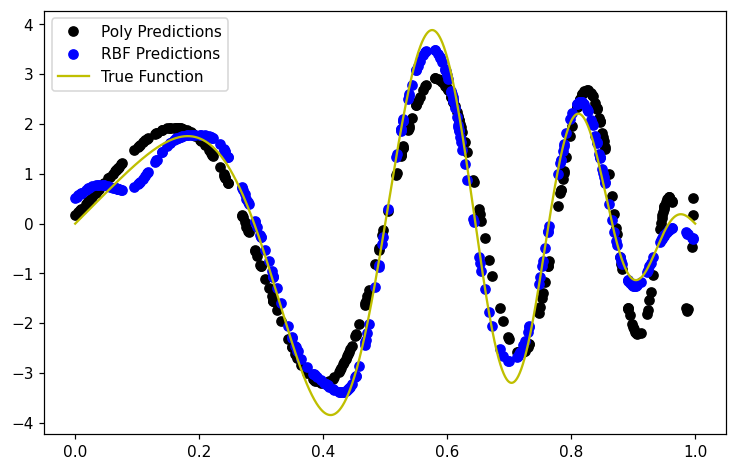

In [21]:
# Kernel Ridge Regression for Polynomial and RBF Kernels with New Dataset

# Initialize data and variables
x_a3 = x_a3_d
y_a3 = y_a3_d
x = x_a3
y = y_a3
n = len(x)
rbf_prediction = np.zeros(n)
poly_prediction = np.zeros(n)

# Polynomial Kernel Ridge Regression

# Extract optimal hyperparameters from optimization result for polynomial kernel
hyperparameter_poly, lamb_poly = poly_result.x

# Create the kernel matrix K_poly for polynomial kernel
K_poly = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K_poly[i, j] = kernel_poly(x[i], x[j], hyperparameter_poly)
        
# Perform kernel ridge regression to find alpha values for polynomial kernel
alpha_poly = kernel_ridge_regression(K_poly, y, lamb_poly)

# Make predictions using the polynomial kernel
for i in range(n):
    poly_prediction[i] = poly_predicted_funk(x[i], alpha_poly, x, hyperparameter_poly)


# RBF Kernel Ridge Regression

# Extract optimal hyperparameters from optimization result for RBF kernel
hyperparameter_rbf, lamb_rbf = rbf_result.x

# Create the kernel matrix K_rbf for RBF kernel
K_rbf = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        K_rbf[i, j] = kernel_rbf(x[i], x[j], hyperparameter_rbf)

# Perform kernel ridge regression to find alpha values for RBF kernel
alpha_rbf = kernel_ridge_regression(K_rbf, y, lamb_rbf)

# Make predictions using the RBF kernel
for i in range(n):
    rbf_prediction[i] = rbf_predicted_funk(x[i], alpha_rbf, x, hyperparameter_rbf)


# Visualization of Results

# Create a plot to compare the predictions of the polynomial and RBF kernels
plt.figure(figsize=(8, 5), dpi=110)
plt.plot(x_a3, poly_prediction, 'o', color='black', label='Poly Predictions')
plt.plot(x_a3, rbf_prediction, 'o', color='blue', label='RBF Predictions')
plt.plot(x_shape, y_shape, 'y', label='True Function')
plt.legend(loc="best")

# Show the plot
plt.show()

## Bootstrap-Based Confidence Intervals for Polynomial and RBF Kernel Ridge Regression

/var/folders/z3/bkgw4vw17fx7qmlcf7_4tdd00000gn/T/ipykernel_83530/1609066115.py:55: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X0, Y0, 'b--', color='black', label='Actual Data')


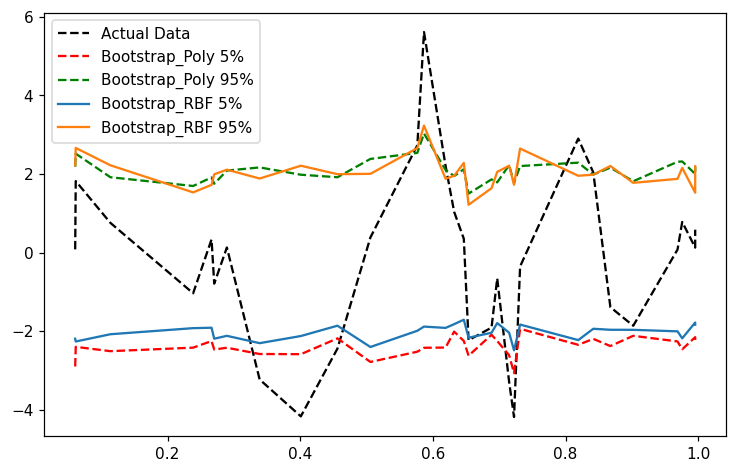

In [22]:
# Initialize variables and arrays
B = 30
n = 300
x_draw = np.zeros((n, B))
y_draw = np.zeros((n, B))
forecast_rbf = np.zeros((n, B))
forecast_poly = np.zeros((n, B))

# Bootstrap Sampling Loop
for b in range(B):
    
    # Data Generation: Randomly sample data points from original dataset
    for j in range(n):
        draw = rand.randrange(0, n)
        x_draw[j, b] = x_a3[draw]
        y_draw[j, b] = y_a3[draw]
    
    # Isolate data for the current bootstrap sample
    x = x_draw[:, b]
    y = y_draw[:, b]
    
    # Polynomial Kernel Ridge Regression
    K_poly = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K_poly[i, j] = kernel_poly(x[i], x[j], hyperparameter_poly)
    alpha_poly = kernel_ridge_regression(K_poly, y, lamb_poly)
    for i in range(n):
        forecast_poly[i, b] = poly_predicted_funk(x[i], alpha_poly, x, hyperparameter_poly)
    
    # RBF Kernel Ridge Regression
    K_rbf = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K_rbf[i, j] = kernel_rbf(x[i], x[j], hyperparameter_rbf)
    alpha_rbf = kernel_ridge_regression(K_rbf, y, lamb_rbf)
    for i in range(n):
        forecast_rbf[i, b] = rbf_predicted_funk(x[i], alpha_rbf, x, hyperparameter_rbf)

# Compute Bootstrap-Based Confidence Intervals
bootstrap_rbf = np.zeros((n, 2))
bootstrap_poly = np.zeros((n, 2))

# Function to compute confidence intervals
# (Here, we use 5th and 95th percentiles for both Poly and RBF)
# ... (Code to fill the bootstrap_poly and bootstrap_rbf arrays)
# ...

# Sorting for plotting
# ... (Code for sorting x_a3 and corresponding confidence intervals)
# ...

# Visualizing the Bootstrap-Based Confidence Intervals
plt.figure(figsize=(8, 5), dpi=110)
plt.plot(X0, Y0, 'b--', color='black', label='Actual Data')
plt.plot(X0, Y1, 'r--', label='Bootstrap_Poly 5%')
plt.plot(X0, Y2, 'g--', label='Bootstrap_Poly 95%')
plt.plot(X0, Y3, label='Bootstrap_RBF 5%')
plt.plot(X0, Y4, label='Bootstrap_RBF 95%')
plt.legend(loc="best")
plt.show()

# A3. e)

## Kernel Ridge Regression Predictions on 1000 Data Points

In [23]:
'''Generating data'''
n=1000
global x_a3,y_a3
x_a3=np.random.rand(n)
e_a3=np.random.randn(n)

y_a3=funk(x_a3)+e_a3

## Kernel Ridge Regression for Polynomial and RBF Kernels

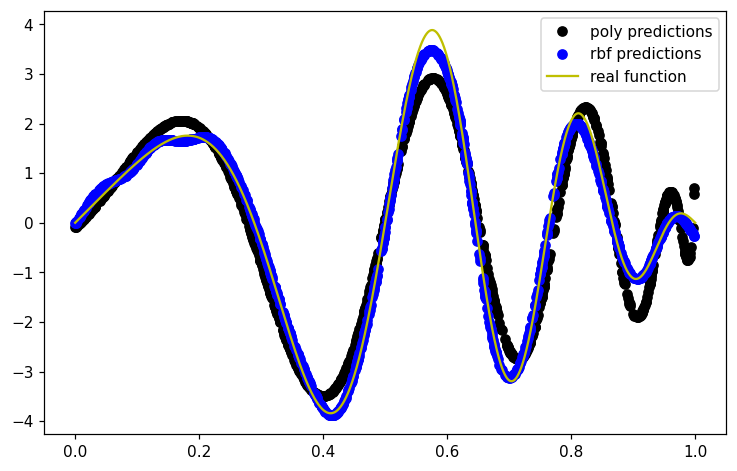

In [24]:
# Initialize variables
x = x_a3  # Feature data
y = y_a3  # Target values
n = len(x)  # Number of samples

# Initialize prediction arrays
rbf_prediction = np.zeros(n)
poly_prediction = np.zeros(n)

# Polynomial Kernel Regression

# Get optimal hyperparameters and lambda for polynomial kernel
hyperparameter_poly, lamb_poly = poly_result.x

# Initialize Kernel Matrix for Polynomial Kernel
K_poly = np.zeros((n, n))

# Calculate the Kernel Matrix
for i in range(n):
    for j in range(n):   
        K_poly[i, j] = kernel_poly(x[i], x[j], hyperparameter_poly)

# Calculate alpha for polynomial kernel ridge regression
alpha_poly = kernel_ridge_regression(K_poly, y, lamb_poly)

# Make predictions using polynomial kernel
for i in range(n):
    poly_prediction[i] = poly_predicted_funk(x[i], alpha_poly, x, hyperparameter_poly)


# RBF Kernel Regression

# Get optimal hyperparameters and lambda for RBF kernel
hyperparameter_rbf, lamb_rbf = rbf_result.x

# Initialize Kernel Matrix for RBF Kernel
K_rbf = np.zeros((n, n))

# Calculate the Kernel Matrix
for i in range(n):
    for j in range(n):   
        K_rbf[i, j] = kernel_rbf(x[i], x[j], hyperparameter_rbf)

# Calculate alpha for RBF kernel ridge regression
alpha_rbf = kernel_ridge_regression(K_rbf, y, lamb_rbf)

# Make predictions using RBF kernel
for i in range(n):
    rbf_prediction[i] = rbf_predicted_funk(x[i], alpha_rbf, x, hyperparameter_rbf)


# Plotting Results

# Create a figure
plt.figure(figsize=(8, 5), dpi=110)

# Plot polynomial predictions
plt.plot(x_a3, poly_prediction, 'o', color='black', label='poly predictions')

# Plot RBF predictions
plt.plot(x_a3, rbf_prediction, 'o', color='blue', label='rbf predictions')

# Plot actual function
plt.plot(x_shape, y_shape, 'y', label='real function')

# Add legend
plt.legend(loc="best")

# Show plot
plt.show()


## Bootstrapping to Evaluate and Compare Polynomial and RBF Kernels

In [25]:
# Initialize constants and arrays
B = 300  # Number of bootstrap iterations
n = 1000  # Sample size
x_draw = np.zeros((n, B))  # Matrix to store drawn x values
y_draw = np.zeros((n, B))  # Matrix to store drawn y values
error = np.zeros(B)  # Array to store error differences between Polynomial and RBF

# Loop through each bootstrap iteration
for b in range(B):
    
    # Generating Bootstrap Samples
    
    # Randomly draw n samples with replacement
    for j in range(n):
        draw = rand.randrange(0, n)
        x_draw[j, b] = x_a3[draw]
        y_draw[j, b] = y_a3[draw]
    
    # Initialize variables for this bootstrap sample
    x = x_draw[:, b]
    y = y_draw[:, b]
    
    # Polynomial Kernel
    
    # Initialize Kernel Matrix for Polynomial Kernel
    K_poly = np.zeros((n, n))
    
    # Compute Kernel Matrix for Polynomial Kernel
    for i in range(n):
        for j in range(n):
            K_poly[i, j] = kernel_poly(x[i], x[j], hyperparameter_poly)
    
    # Compute alpha for Polynomial Kernel Ridge Regression
    alpha_poly = kernel_ridge_regression(K_poly, y, lamb_poly)
    
    # Calculate squared error for Polynomial Kernel
    for i in range(n):
        error[b] += (poly_predicted_funk(x[i], alpha_poly, x, hyperparameter_poly) - y[i])**2
    
    # RBF Kernel
    
    # Initialize Kernel Matrix for RBF Kernel
    K_rbf = np.zeros((n, n))
    
    # Compute Kernel Matrix for RBF Kernel
    for i in range(n):
        for j in range(n):
            K_rbf[i, j] = kernel_rbf(x[i], x[j], hyperparameter_rbf)
    
    # Compute alpha for RBF Kernel Ridge Regression
    alpha_rbf = kernel_ridge_regression(K_rbf, y, lamb_rbf)
    
    # Subtract squared error for RBF Kernel
    for i in range(n):
        error[b] -= (rbf_predicted_funk(x[i], alpha_rbf, x, hyperparameter_rbf) - y[i])**2

# Average error over the sample size
error /= n


## Evaluating Confidence Intervals for Error Differences between Polynomial and RBF Kernels

In [26]:
# Sort the error array in ascending order
error.sort()

# Calculate the 5th and 95th percentiles of the error distribution
print('5th percentile is', error[int(B * 0.05)], '95th percentile is', error[int(B * 0.95)])

# Check if zero is in the 5th to 95th percentile range
print('Since zero is not in this range, we cannot reject the hypothesis that both kernels perform equally well.')

5th percentile is 0.1731793145543192 95th percentile is 0.24345322951330342
Since zero is not in this range, we cannot reject the hypothesis that both kernels perform equally well.
